In [1]:
# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Draw inline
%matplotlib inline

# Set seaborn style
sns.set_context("notebook", font_scale=1.5)

# Sklearn preprocessing
from sklearn.preprocessing import OneHotEncoder

# Sklearn libraries.
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

/Users/divyas/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/divyas/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Prepare Data

In [2]:
# Load full data set (combined with actions)
train = pd.read_csv('../data/train_combined_actions.zip')
print("train shape:", train.shape)

/Users/divyas/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


('train shape:', (213451, 541))


In [3]:
# subset full data set to only include users that have sessions data, remove action counts for now 

mod_train = train[train.count_actions.isnull() != True]
mod_train = mod_train.reset_index().iloc[: , 2:]

# Shuffle training set
shuffle = np.random.permutation(np.arange(mod_train.shape[0]))
mod_train = mod_train.reindex(shuffle)

# Split labels from training set
train_labels = mod_train['country_destination']
train_data = mod_train.drop('country_destination', axis=1)

# split into train and dev sets (12%)
dev_data, dev_labels = train_data[:8850], train_labels[:8850]
train_data, train_labels = train_data[8850:], train_labels[8850:]

# use training set without action counts -- less columns to process and action counts are sparse
col = train_data.columns.get_loc("last_action") # last column index before action columns begin
train_data = train_data.iloc[: , :col+1]
dev_data = dev_data.iloc[: , :col+1]

print("train data:", train_data.shape)
print("train data:", train_labels.shape)
print("dev data:", dev_data.shape)
print("dev data:", dev_labels.shape)

('train data:', (64965, 25))
('train data:', (64965,))
('dev data:', (8850, 25))
('dev data:', (8850,))


### Encode Labels

In [4]:
# Output 3 classes: NDF, US, Non-US
def country(col):
    if col == 'NDF':
        return "NDF"
    elif col == 'US':
        return 'US'
    else:
        return 'non-US'
    
t = train_labels.apply(country)
d = dev_labels.apply(country)

# Convert labels to numeric
le = preprocessing.LabelEncoder() # Initialize label_encoder
t_lab, d_lab = le.fit_transform(t), le.fit_transform(d)

print(t_lab.shape)
print(d_lab.shape)

country_code = dict(zip(le.classes_, le.transform(le.classes_)))
print(country_code)

(64965,)
(8850,)
{'non-US': 2, 'US': 1, 'NDF': 0}


### Iterating through features using Logistic Regression 

In [5]:
list(mod_train)

['date_account_created',
 'timestamp_first_active',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination',
 'month_created',
 'season_created',
 'year_created',
 'bin_age',
 'bin_lang',
 'days_since_creation',
 'first_hour',
 'count_actions',
 'number_devices',
 'longest_session',
 'total_time',
 'last_action',
 '10',
 '11',
 '12',
 '15',
 'about_us',
 'accept_decline',
 'account',
 'acculynk_bin_check_failed',
 'acculynk_bin_check_success',
 'acculynk_load_pin_pad',
 'acculynk_pin_pad_error',
 'acculynk_pin_pad_inactive',
 'acculynk_pin_pad_success',
 'acculynk_session_obtained',
 'active',
 'add_business_address_colorbox',
 'add_guest_colorbox',
 'add_guests',
 'add_note',
 'agree_terms_check',
 'agree_terms_uncheck',
 'airbnb_picks',
 'airbrb',
 'ajax_check_dates',
 'ajax_get_referrals_amt',
 'ajax_get_results',
 'ajax_goo

In [15]:
def binarize(data, cutoff, column): 
    t_bin = pd.get_dummies(data[column])[cutoff:]
    d_bin = pd.get_dummies(data[column])[:cutoff]
    return t_bin, d_bin

# iterate over categorical features and run logistic regression
cutoff = 8850

Cs = {'C':list(np.linspace(0, 100, 3))[1:]}

cat_feat = ['bin_lang', 'bin_age', 'gender', 'signup_method', 'first_hour',
            'first_browser']

# underperforming:
# 'season_created', 'first_device_type', signup_app', 'affiliate_channel', 

# Initialize with first feature column 
t, d = binarize(mod_train, cutoff, cat_feat[0])

# Run regressions on l1, l2 penalty
lm = LogisticRegression(C = 50, penalty = "l1")
lm.fit(t, t_lab)
score1 = lm.score(d, d_lab)
lm = LogisticRegression(C = 50, penalty = "l2")
lm.fit(t, t_lab)
score2 = lm.score(d, d_lab)

print("Initial feature:", cat_feat[0])
print("L1 num cols: ", t.shape[1], "score:", score1)
print("L2 num cols: ", t.shape[1], "score:", score2)

pred = lm.predict(d)
conf = confusion_matrix(pred, d_lab)
print(conf)


# Iterate over categorical features starting on second item in the list
for x in cat_feat[1:]:
    t_bin, d_bin = binarize(mod_train, cutoff, x)
    t = np.concatenate((t, t_bin), axis=1)
    d = np.concatenate((d, d_bin), axis=1)

    # Run logistic regression on data set with added feature
    print("\nAdded Feature:", x)
    lm = LogisticRegression(C = 50, penalty = "l1")
    lm.fit(t, t_lab)
    score1 = lm.score(d, d_lab)
    print("L1 num cols: ", t.shape[1], "score:", score1)
    
    lm = LogisticRegression(C = 50, penalty = "l2")
    lm.fit(t, t_lab)
    score2 = lm.score(d, d_lab)
    print("L2 num cols: ", t.shape[1], "score:", score2)

    pred = lm.predict(d)
    conf = confusion_matrix(pred, d_lab)
    print(conf)


# Iterate over numerical features
num_feat = ['count_actions']

# underperforming:
# 'days_since_creation', 'total_time', 'number_devices', 'longest_session', 'request_photography'

for y in num_feat:
    # get column and fill in NaNs with column mean
    mean = np.mean(mod_train[y][cutoff:])
    t_col = mod_train[y][cutoff:].fillna(mean)
    t_col = t_col.reshape(t.shape[0], 1)
    d_col = mod_train[y][:cutoff].fillna(mean)
    d_col = d_col.reshape(d.shape[0], 1)

    # add column to previous training set
    t = np.concatenate((t, t_col), axis=1)
    d = np.concatenate((d, d_col), axis=1)

    # Run Logistic Regression
    print("\nAdded Feature:", y)
    lm = LogisticRegression(C = 50, penalty = "l1")
    lm.fit(t, t_lab)
    score1 = lm.score(d, d_lab)
    print("L1 num cols: ", t.shape[1], "score:", score1)
    
    lm = LogisticRegression(C = 50, penalty = "l2")
    lm.fit(t, t_lab)
    score2 = lm.score(d, d_lab)
    print("L2 num cols: ", t.shape[1], "score:", score2)

    pred = lm.predict(d)
    conf = confusion_matrix(pred, d_lab)
    print(conf)
    
    

('Initial feature:', 'bin_lang')
('L1 num cols: ', 5, 'score:', 0.60474576271186442)
('L2 num cols: ', 5, 'score:', 0.60474576271186442)
[[5352 2467 1031]
 [   0    0    0]
 [   0    0    0]]
('\nAdded Feature:', 'bin_age')
('L1 num cols: ', 10, 'score:', 0.60474576271186442)
('L2 num cols: ', 10, 'score:', 0.60474576271186442)
[[5352 2467 1031]
 [   0    0    0]
 [   0    0    0]]
('\nAdded Feature:', 'gender')
('L1 num cols: ', 14, 'score:', 0.62192090395480226)
('L2 num cols: ', 14, 'score:', 0.62192090395480226)
[[5128 2091  889]
 [ 224  376  142]
 [   0    0    0]]
('\nAdded Feature:', 'signup_method')
('L1 num cols: ', 17, 'score:', 0.65186440677966107)
('L2 num cols: ', 17, 'score:', 0.65186440677966107)
[[4457 1155  499]
 [ 895 1312  532]
 [   0    0    0]]
('\nAdded Feature:', 'first_hour')
('L1 num cols: ', 41, 'score:', 0.65186440677966107)
('L2 num cols: ', 41, 'score:', 0.65186440677966107)
[[4493 1191  530]
 [ 857 1275  500]
 [   2    1    1]]
('\nAdded Feature:', 'first_

/Users/divyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/divyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


('L1 num cols: ', 77, 'score:', 0.65209039548022596)
('L2 num cols: ', 77, 'score:', 0.65186440677966107)
[[4594 1291  553]
 [ 756 1173  476]
 [   2    3    2]]


### Priors on country_destination

Check to see if accuracy is better than the % of NDF labels. 

In [7]:
dev_labels.value_counts()/ sum(dev_labels.value_counts())

NDF      0.604746
US       0.278757
other    0.048701
FR       0.018757
IT       0.011525
ES       0.011299
GB       0.008475
CA       0.006667
NL       0.004294
DE       0.003277
AU       0.002034
PT       0.001469
Name: country_destination, dtype: float64

# Confusion Matrix

In [17]:
unique_pred = np.unique(pred)
unique_d_lab = np.unique(d_lab)

In [19]:
unique_pred

array([0, 1, 2])

In [20]:
unique_d_lab

array([0, 1, 2])

Building testing confusion matrix...


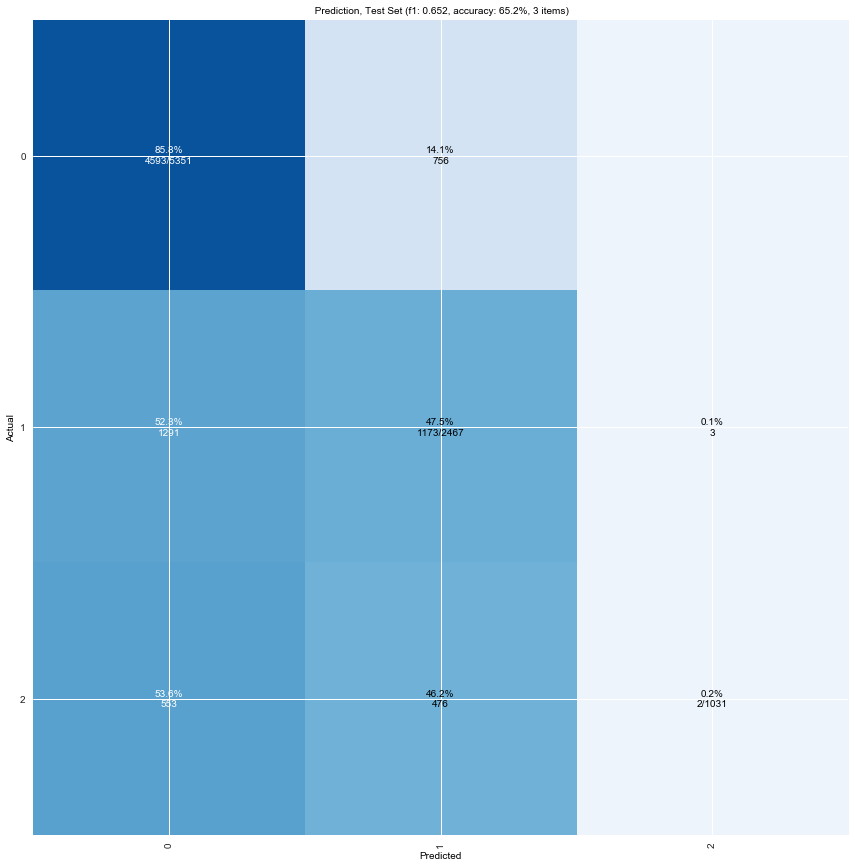

In [24]:
import numpy as np, pylab as pl
# get overall accuracy and F1 score to print at top of plot
pscore = metrics.accuracy_score(d_lab, pred)
#score = metrics.f1_score(y_test, pred, pos_label=list(set(y_test)))
# get size of the full label set
dur = len(unique_d_lab)
print "Building testing confusion matrix..."
# initialize score matrices
trueScores = np.zeros(shape=(dur,dur))
predScores = np.zeros(shape=(dur,dur))
# populate totals
for i in xrange(len(d_lab)-1):
  trueIdx = d_lab[i]
  predIdx = pred[i]
  trueScores[trueIdx,trueIdx] += 1
  predScores[trueIdx,predIdx] += 1
# create %-based results
trueSums = np.sum(trueScores,axis=0)
conf = np.zeros(shape=predScores.shape)
for i in xrange(len(predScores)):
  for j in xrange(dur):
    conf[i,j] = predScores[i,j] / trueSums[i]
# plot the confusion matrix
hq = pl.figure(figsize=(15,15));
aq = hq.add_subplot(1,1,1)
aq.set_aspect(1)
res = aq.imshow(conf,cmap=pl.get_cmap('Blues'),interpolation='nearest',vmin=-0.05,vmax=1.)
width = len(conf)
height = len(conf[0])
done = []
# label each grid cell with the misclassification rates
for w in xrange(width):
  for h in xrange(height):
      pval = conf[w][h]
      c = 'k'
      rais = w
      if pval > 0.5: c = 'w'
      if pval > 0.001:
        if w == h:
          aq.annotate("{0:1.1f}%\n{1:1.0f}/{2:1.0f}".format(pval*100.,predScores[w][h],trueSums[w]), xy=(h, w), 
                  horizontalalignment='center',
                  verticalalignment='center',color=c,size=10)
        else:
          aq.annotate("{0:1.1f}%\n{1:1.0f}".format(pval*100.,predScores[w][h]), xy=(h, w), 
                  horizontalalignment='center',
                  verticalalignment='center',color=c,size=10)
# label the axes
pl.xticks(range(width), unique_d_lab[:width],rotation=90,size=10)
pl.yticks(range(height), unique_d_lab[:height],size=10)
# add a title with the F1 score and accuracy
aq.set_title(" Prediction, Test Set (f1: "+"{0:1.3f}".format(pscore)+', accuracy: '+'{0:2.1f}%'.format(100*pscore)+", " + str(len(unique_d_lab)) + " items)",fontname='Arial',size=10,color='k')
aq.set_ylabel("Actual",fontname='Arial',size=10,color='k')
aq.set_xlabel("Predicted",fontname='Arial',size=10,color='k')
pl.grid(b=True,axis='both')
# save it
pl.savefig("pred.conf.test.png")